In [132]:
import h5py
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [133]:
f_data = h5py.File("./BikeNYC/NYC14_M16x8_T60_NewEnd.h5")
BikeNYC_date = f_data['date']
BikeNYC_data = f_data['data']
print(f'date: \n{BikeNYC_date[0]}\n shape:{BikeNYC_date.shape} \n in_flow:\n{BikeNYC_data[0][0]} \n out_flow: \n{BikeNYC_data[0][1]}')
print(BikeNYC_data.shape)

date: 
b'2014040101'
 shape:(4392,) 
 in_flow:
[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 4. 1. 1. 0. 0.]
 [0. 0. 2. 5. 0. 2. 2. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0.]
 [0. 1. 3. 1. 4. 2. 0. 0.]
 [0. 3. 3. 6. 3. 0. 0. 0.]
 [0. 2. 6. 5. 5. 0. 0. 0.]
 [0. 6. 3. 8. 1. 0. 0. 0.]
 [0. 2. 0. 2. 0. 0. 0. 0.]
 [3. 4. 5. 0. 1. 0. 1. 0.]
 [0. 2. 2. 1. 0. 0. 2. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 1. 0.]
 [0. 0. 0. 1. 2. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1.]] 
 out_flow: 
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 3. 2. 1. 0. 0.]
 [0. 0. 0. 3. 0. 1. 0. 0.]
 [0. 1. 1. 2. 1. 0. 0. 0.]
 [0. 4. 2. 1. 2. 0. 0. 0.]
 [0. 1. 5. 5. 3. 0. 0. 0.]
 [0. 2. 5. 3. 4. 0. 0. 0.]
 [0. 2. 4. 7. 0. 0. 0. 0.]
 [1. 1. 2. 9. 1. 0. 0. 0.]
 [1. 1. 2. 2. 1. 0. 2. 0.]
 [1. 2. 2. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 2. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
(4392, 2, 16, 8)


In [134]:
BikeNYC_data_square = np.concatenate((BikeNYC_data[:,0,:,:],BikeNYC_data[:,1,:,:]),axis=2)
print(BikeNYC_data_square.shape)
print(BikeNYC_data_square[0,:,:])

(4392, 16, 16)
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 4. 1. 1. 0. 0. 0. 0. 0. 3. 2. 1. 0. 0.]
 [0. 0. 2. 5. 0. 2. 2. 0. 0. 0. 0. 3. 0. 1. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 1. 1. 2. 1. 0. 0. 0.]
 [0. 1. 3. 1. 4. 2. 0. 0. 0. 4. 2. 1. 2. 0. 0. 0.]
 [0. 3. 3. 6. 3. 0. 0. 0. 0. 1. 5. 5. 3. 0. 0. 0.]
 [0. 2. 6. 5. 5. 0. 0. 0. 0. 2. 5. 3. 4. 0. 0. 0.]
 [0. 6. 3. 8. 1. 0. 0. 0. 0. 2. 4. 7. 0. 0. 0. 0.]
 [0. 2. 0. 2. 0. 0. 0. 0. 1. 1. 2. 9. 1. 0. 0. 0.]
 [3. 4. 5. 0. 1. 0. 1. 0. 1. 1. 2. 2. 1. 0. 2. 0.]
 [0. 2. 2. 1. 0. 0. 2. 1. 1. 2. 2. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 0. 2. 1. 0. 1. 0.]
 [0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [172]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(seq.shape[0]- window_size):
        result.append(seq[i: i+window_size])
    result = np.array(result)
    return result

def MLPreshape(set):
    set = set.reshape((set.shape[0],set.shape[1],-1))
    return set

def MLPreshape_inverse(set):
    set = set.reshape((set.shape[0],set.shape[1],16,16))
    return set

data_num = BikeNYC_date.shape[0]
# flow_in_num = 0
train_seq = BikeNYC_data_square[:int(data_num*0.7),:,:]
validation_seq = BikeNYC_data_square[int(data_num*0.7):int(data_num*0.8),:,:]
test_seq = BikeNYC_data_square[int(data_num*0.8):,:,:]
print(train_seq.shape,validation_seq.shape,test_seq.shape)

window_size = 9
train_set = sliding_window(train_seq, window_size)
validation_set = sliding_window(validation_seq, window_size)
test_set = sliding_window(test_seq, window_size)
print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

train_set = MLPreshape(train_set)
validation_set = MLPreshape(validation_set)
test_set = MLPreshape(test_set)

print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

(3074, 16, 16) (439, 16, 16) (879, 16, 16)
(3065, 9, 16, 16)
(430, 9, 16, 16)
(870, 9, 16, 16)
(3065, 9, 256)
(430, 9, 256)
(870, 9, 256)


In [148]:
dropout_parameter = 0.01
class OutputNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim1, hidden_dim2, action_dim):
        super(OutputNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim1)
        self.fc4 = torch.nn.LayerNorm(hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc5 = torch.nn.LayerNorm(hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, action_dim)
        self.fc6 = torch.nn.Dropout(dropout_parameter)

    def forward(self, x):
        x = F.leaky_relu_(self.fc1(x))
        x = self.fc4(x)
        x = F.leaky_relu_(self.fc2(x))
        x = self.fc5(x)
        x = F.leaky_relu_(self.fc3(x))
        return self.fc6(x)


In [137]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [138]:
def next_batch(data, batch_size):
    data_length = data.shape[0]
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [188]:
class ConvolutionNet(torch.nn.Module):
    def __init__(self):
        super(ConvolutionNet, self).__init__()
        self.block1 = nn.Sequential(
                            nn.Conv2d(6, 64, kernel_size=4, stride=2),
                            nn.LeakyReLU(0.02),
                            # nn.Dropout(dropout_parameter),
                            nn.BatchNorm2d(64),

                            nn.Conv2d(64,128,kernel_size=3, stride=2),
                            nn.LeakyReLU(0.02),
                            # nn.Dropout(dropout_parameter),
                            nn.BatchNorm2d(128),

                            nn.Conv2d(128,120,kernel_size=3, stride=1),
                            nn.LeakyReLU(0.02),
                            #
                            nn.BatchNorm2d(120),
                            # nn.Dropout(dropout_parameter)
        )

    def forward(self, x):
        x = self.block1(x.view((x.shape[0],6,16,16)))
        # print(x.shape)
        x = x.squeeze()
        return x

In [189]:
#初始化模型
device = 'cpu'
Convolution_Net = ConvolutionNet()
torch_lstm = nn.LSTM(input_size=20, hidden_size=32, num_layers=1, batch_first=True)
output_model = OutputNet(state_dim=32, hidden_dim1=64, hidden_dim2=128, action_dim=16*16)

In [190]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(torch_lstm.parameters()) + list(output_model.parameters()) + list(Convolution_Net.parameters()), lr=1e-4, weight_decay=1e-4)

In [192]:
#保存打印文件
f = open("./date/Dropout+L2.txt", 'a+')

In [191]:
# 这两句只在第二次运行这个框架时运行，是为了重载文件流防止内存溢出。
f.close()
os.remove("./date/Dropout+L2.txt")

In [ ]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch
batch_size = 128
def train_fun(batch_data):
    x, label = batch[:, :6, :], batch[:, -1, :]
    x = Convolution_Net(x)
    out, hidden = torch_lstm(x.view((x.shape[0], 6, -1)))  # out: (batch_size, seq_len, hidden_size)
    return output_model(out[:, -1, :]), label # -1 means the last data

def train_fun_for_update(prediction_fun, label_fun):
    loss = loss_func(prediction_fun, label_fun) #+ loss_func(prediction2, label2) + loss_func(prediction3, label3)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(500):

    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=batch_size):
        #每一个batch的开始时间
        batchstart = time.time()

        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前6个值作为历史，最后一个值作为预测值。
        x_data = batch[:, :7, :]
        # print(x_data.shape)
        prediction1, label1 = train_fun(x_data) # (batch)
        loss1 = train_fun_for_update(prediction1, batch[:, 6, :]).detach().cpu().numpy()
        x_data = batch[:, 1:8, :]
        x_data[:,5,:] = prediction1.detach().cpu()
        prediction2, label2 = train_fun(x_data)
        loss2 = train_fun_for_update(prediction2, batch[:, 7, :]).detach().cpu().numpy()
        x_data = batch[:, 2:9, :]
        x_data[:,5,:] = prediction2.detach().cpu()
        prediction3, label3 = train_fun(x_data)
        loss3 = train_fun_for_update(prediction3, batch[:, 8, :]).detach().cpu().numpy()
        # print(prediction1.shape, prediction2.shape, prediction3.shape, label1.shape, label2.shape, label3.shape)

        trained_batches += 1
        train_log.append(loss1+loss2+loss3)
        train_batch_time = (time.time() - batchstart)

        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss1+loss2+loss3, train_batch_time))
            print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss1+loss2+loss3, train_batch_time),file=f)
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction1 = []
            all_prediction2 = []
            all_prediction3 = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x_data = batch[:, :7, :]
                out1, label1 = train_fun(x_data)
                x_data = batch[:, 1:8, :]
                x_data[:,5,:] = out1
                out2, label2 = train_fun(x_data)
                x_data = batch[:, 2:9, :]
                x_data[:,5,:] = out2
                out3, label3 = train_fun(x_data)
                prediction1 = out1  # (batch)
                prediction2 = out2
                prediction3 = out3
                all_prediction1.append(prediction1.detach().cpu().numpy())
                all_prediction2.append(prediction2.detach().cpu().numpy())
                all_prediction3.append(prediction3.detach().cpu().numpy())

            all_prediction1 = np.concatenate(all_prediction1)
            all_prediction2 = np.concatenate(all_prediction2)
            all_prediction3 = np.concatenate(all_prediction3)
            all_label1 = test_set[:, 6, :]
            all_label2 = test_set[:, 7, :]
            all_label3 = test_set[:, 8, :]
            # 没有进行反归一化操作。也可以用，但是效果不好，所以就去掉了
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label1, all_prediction1))+math.sqrt(mse(all_label2, all_prediction2))+math.sqrt(mse(all_label3, all_prediction3))
            mae_score = mae(all_label1, all_prediction1)+mae(all_label2, all_prediction2)+mae(all_label3, all_prediction3)
            mape_score = mape(all_label1, all_prediction1)+mape(all_label2, all_prediction2)+mape(all_label3, all_prediction3)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 100, train_loss 151.560120,Time used 0.109798s
***************************test_batch 100, test_rmse_loss 24.604364,test_mae_loss 10.665033,test_mape_loss 182.583154,Time used 0.298109s
batch 200, train_loss 169.831299,Time used 0.094175s
***************************test_batch 200, test_rmse_loss 24.687816,test_mae_loss 10.690658,test_mape_loss 179.006996,Time used 0.266372s
batch 300, train_loss 148.504150,Time used 0.094164s
***************************test_batch 300, test_rmse_loss 24.729288,test_mae_loss 10.715126,test_mape_loss 179.167670,Time used 0.282571s
batch 400, train_loss 158.932434,Time used 0.109838s
***************************test_batch 400, test_rmse_loss 24.634847,test_mae_loss 10.690450,test_mape_loss 180.480452,Time used 0.282519s
batch 500, train_loss 131.277313,Time used 0.094146s
***************************test_batch 500, test_rmse_loss 24.510506,test_mae_loss 10.652173,test_mape_loss 181.590874,Time used 0.298147s
batch 600, train_loss 157.230011,Time used 0.

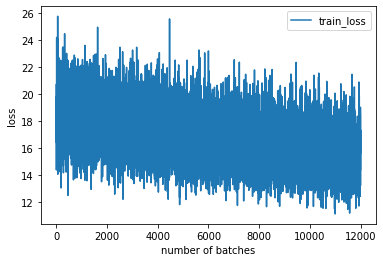

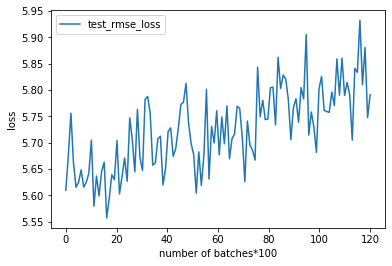

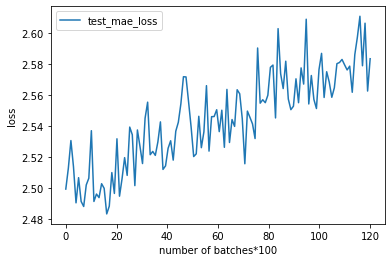

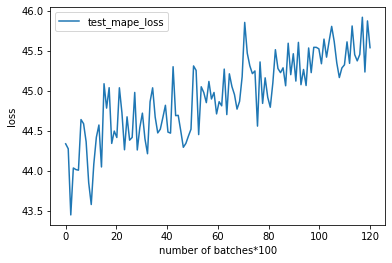

In [158]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtrainloss1_L2_dropout.jpg')
plt.show()
#plt.clf()
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmseloss1_L2_dropout.jpg')
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmaeloss1_L2_dropout.jpg')
plt.show()
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/1.4torchLSTMtestrmapeloss1_L2_dropout.jpg')
plt.show()

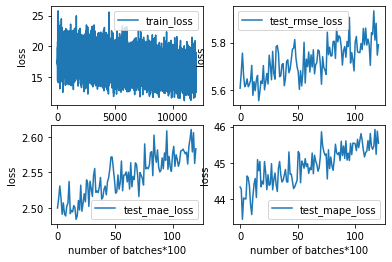

In [159]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.subplot(2, 2, 1)
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 2)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 3)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.subplot(2, 2, 4)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.savefig('./figure/LSTM-4-photo_L2_dropout.jpg')
plt.show()
#plt.clf()